# Experiment 1: Minimum Neurons in Hidden Layer

## Objective
This experiment aims to determine the minimum number of neurons required in the hidden layer to achieve a mean absolute error than 0.009.

## Problem Specification
- **Input**: x, y coordinates
- **Output**: z² (squared value)
- **Task**: Implementation of the Pythagorean theorem using a neural network

## Expected Outcome
The experiment will identify the optimal number of neurons needed in the hidden layer to accurately compute the Pythagorean theorem while maintaining a mean absolute error below 0.009.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Enhanced model with more flexibility
class EnhancedQuadraticNetwork(nn.Module):
    def __init__(self, hidden_size, activation='relu', layers=1, second_activation=None):
        super(EnhancedQuadraticNetwork, self).__init__()
        
        # Primary activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
            
        # Secondary activation (optional)
        if second_activation:
            if second_activation == 'relu':
                self.second_activation = nn.ReLU()
            elif second_activation == 'tanh':
                self.second_activation = nn.Tanh()
            elif second_activation == 'sigmoid':
                self.second_activation = nn.Sigmoid()
            elif second_activation == 'leaky_relu':
                self.second_activation = nn.LeakyReLU(0.1)
        else:
            self.second_activation = self.activation
        
        # Build the layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, hidden_size))
        
        for i in range(layers-1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if i == 0:
                x = self.activation(layer(x))
            else:
                x = self.second_activation(layer(x))
        return self.output(x)

def train_and_evaluate(hidden_size, activation='relu', layers=1, second_activation=None, 
                       max_epochs=3000, threshold=0.009, lr=0.01):
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create model
    model = EnhancedQuadraticNetwork(hidden_size, activation, layers, second_activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Use L1Loss (MAE)
    criterion = nn.L1Loss()
    
    # Generate more data for better training
    x_train = torch.FloatTensor(np.random.uniform(-1, 1, (4000, 2)))
    y_train = torch.FloatTensor((x_train[:, 0]**2 + x_train[:, 1]**2).reshape(-1, 1))
    
    # Validation data
    x_val = torch.FloatTensor(np.random.uniform(-1, 1, (1000, 2)))
    y_val = torch.FloatTensor((x_val[:, 0]**2 + x_val[:, 1]**2).reshape(-1, 1))
    
    # Test data
    x_test = torch.FloatTensor(np.random.uniform(-1, 1, (1000, 2)))
    y_test = torch.FloatTensor((x_test[:, 0]**2 + x_test[:, 1]**2).reshape(-1, 1))
    
    best_val_loss = float('inf')
    patience = 50  # Increased patience
    no_improve = 0
    
    val_losses = []
    test_losses = []
    
    # Training loop
    for epoch in range(max_epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Evaluate periodically to save computation
        if epoch % 10 == 0 or epoch == max_epochs - 1:
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                val_losses.append(val_loss.item())
                
                test_outputs = model(x_test)
                test_loss = criterion(test_outputs, y_test)
                test_losses.append(test_loss.item())
                
                # Print progress occasionally
                if epoch % 200 == 0:
                    print(f"  Epoch {epoch}: Val MAE: {val_loss.item():.6f}, Test MAE: {test_loss.item():.6f}")
                
                # Track best validation loss for early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improve = 0
                else:
                    no_improve += 1
                
                # Check if both validation and test MAE meet the threshold
                if val_loss < threshold and test_loss < threshold:
                    print(f"✓ Target achieved with {hidden_size} neurons, {activation}, {layers} layers, epoch {epoch+1}")
                    print(f"  Validation MAE: {val_loss.item():.6f}, Test MAE: {test_loss.item():.6f}")
                    return model, val_loss.item(), test_loss.item(), epoch+1, True, val_losses, test_losses
                
                # Early stopping with increased patience
                if no_improve >= patience and epoch > 500:  # Ensure minimum training
                    print(f"× Failed with {hidden_size} neurons, {activation}, {layers} layers (early stopping)")
                    print(f"  Best validation MAE: {best_val_loss:.6f}, Test MAE: {test_loss.item():.6f}")
                    return model, best_val_loss, test_loss.item(), epoch+1, False, val_losses, test_losses
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    
    print(f"× Failed with {hidden_size} neurons, {activation}, {layers} layers (max epochs)")
    print(f"  Final validation MAE: {val_loss.item():.6f}, Test MAE: {test_loss.item():.6f}")
    return model, val_loss.item(), test_loss.item(), max_epochs, False, val_losses, test_losses

def test_model(model, num_points=3):
    # Define test points
    test_points = [
        [0.5, 0.5],    # Expected: 0.5² + 0.5² = 0.5
        [1.0, 0.0],    # Expected: 1.0² + 0.0² = 1.0
        [-0.3, 0.4],   # Expected: (-0.3)² + 0.4² = 0.09 + 0.16 = 0.25
    ][:num_points]
    
    model.eval()
    with torch.no_grad():
        errors = []
        for point in test_points:
            x, y = point
            input_tensor = torch.FloatTensor([[x, y]])
            expected = x**2 + y**2
            prediction = model(input_tensor).item()
            error = abs(prediction - expected)
            errors.append(error)
            
            print(f"  Input: ({x:.1f}, {y:.1f}), Expected: {expected:.6f}, Predicted: {prediction:.6f}, Error: {error:.6f}")
        
        avg_error = sum(errors) / len(errors)
        print(f"  Average Error: {avg_error:.6f}")
    
    return avg_error

# Try more advanced configurations
print("Experimenting with enhanced configurations for MAE < 0.009")
print("=" * 70)

configs = [
    # Wider networks
    (8, 'tanh', 1, None),
    (10, 'tanh', 1, None),
    (15, 'tanh', 1, None),
    
    # Multiple layers
    (5, 'tanh', 2, None),
    (6, 'tanh', 2, None),
    (8, 'tanh', 2, None),
    
    # Leaky ReLU
    (5, 'leaky_relu', 1, None),
    (8, 'leaky_relu', 1, None),
    
    # Mixed activations
    (5, 'tanh', 2, 'relu'),
    (8, 'tanh', 2, 'leaky_relu'),
    
    # Even deeper networks
    (5, 'tanh', 3, None),
]

results = []
for config in configs:
    neurons, activation, layers, second_act = config
    print(f"\nTesting: {neurons} neurons, {activation}, {layers} layers, secondary: {second_act}")
    model, val_loss, test_loss, epochs, success, val_losses, test_losses = train_and_evaluate(
        neurons, activation, layers, second_act)
    
    # Store even if not successful for comparison
    result = {
        'neurons': neurons,
        'activation': activation,
        'layers': layers,
        'second_activation': second_act,
        'epochs': epochs,
        'val_mae': val_loss,
        'test_mae': test_loss,
        'success': success,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'model': model
    }
    
    if success:
        print("\nPrediction Examples:")
        avg_error = test_model(model)
        result['avg_error'] = avg_error
        results.append(result)
        
        # If we've found a good solution, we can stop
        if avg_error < 0.009:
            print("\n✓ Found excellent configuration")
            break
    else:
        # Store the result anyway for comparison
        print("\nPrediction Examples (even though target not met):")
        avg_error = test_model(model)
        result['avg_error'] = avg_error
        results.append(result)

# Show summary of all configurations
print("\n" + "=" * 100)
print("Configuration Results (sorted by validation MAE):")
print("-" * 100)
print(f"{'Neurons':^8} | {'Activation':^10} | {'Layers':^8} | {'Epochs':^8} | {'Val MAE':^10} | {'Test MAE':^10} | {'Avg Error':^10} | {'Success':^10}")
print("-" * 100)

# Sort by validation MAE (best first)
for r in sorted(results, key=lambda x: x['val_mae']):
    print(f"{r['neurons']:^8} | {r['activation']:^10} | {r['layers']:^8} | {r['epochs']:^8} | " +
         f"{r['val_mae']:.6f} | {r['test_mae']:.6f} | {r['avg_error']:.6f} | {'✓' if r['success'] else '×'}")

# Find the best configuration regardless of success
best_config = min(results, key=lambda x: x['val_mae'])

print("\nBest Overall Configuration:")
print(f"- {best_config['neurons']} neurons with {best_config['activation']} activation and {best_config['layers']} layers")
print(f"- Trained for {best_config['epochs']} epochs")
print(f"- Validation MAE: {best_config['val_mae']:.6f}, Test MAE: {best_config['test_mae']:.6f}")
print(f"- Average prediction error: {best_config['avg_error']:.6f}")
print(f"- Success: {'Yes' if best_config['success'] else 'No'}")

if not any(r['success'] for r in results):
    print("\nNo configuration achieved the target MAE < 0.009.")
    print("Consider:")
    print("1. Training longer (increase max_epochs)")
    print("2. Using a custom architecture with quadratic components")
    print("3. Relaxing the MAE threshold slightly")

Experimenting with enhanced configurations for MAE < 0.009

Testing: 8 neurons, tanh, 1 layers, secondary: None
  Epoch 0: Val MAE: 0.644388, Test MAE: 0.691997
  Epoch 200: Val MAE: 0.075211, Test MAE: 0.073508
  Epoch 400: Val MAE: 0.013913, Test MAE: 0.014741
✓ Target achieved with 8 neurons, tanh, 1 layers, epoch 561
  Validation MAE: 0.007791, Test MAE: 0.008605

Prediction Examples:
  Input: (0.5, 0.5), Expected: 0.500000, Predicted: 0.500468, Error: 0.000468
  Input: (1.0, 0.0), Expected: 1.000000, Predicted: 0.959383, Error: 0.040617
  Input: (-0.3, 0.4), Expected: 0.250000, Predicted: 0.246900, Error: 0.003100
  Average Error: 0.014728

Testing: 10 neurons, tanh, 1 layers, secondary: None
  Epoch 0: Val MAE: 0.666434, Test MAE: 0.690593
  Epoch 200: Val MAE: 0.062122, Test MAE: 0.063541
  Epoch 400: Val MAE: 0.012449, Test MAE: 0.013691
✓ Target achieved with 10 neurons, tanh, 1 layers, epoch 551
  Validation MAE: 0.007979, Test MAE: 0.008822

Prediction Examples:
  Input: (0.

### Conclusion 

1. With proper activation function we just need 15 neurons in the hidden layer to learn the quadratic equation.
2. But wait what if we use activation functions in parallell so that model learn which to pick and how much lets do in the next experiment

Experimenting with dual-activation networks for MAE < 0.009

Testing dual-activation network with 3 neurons and 1 layers
  Epoch 0: Val MAE: 0.398523, Test MAE: 0.390130
  Epoch 200: Val MAE: 0.137323, Test MAE: 0.145710
  Epoch 400: Val MAE: 0.027936, Test MAE: 0.029419
  Epoch 600: Val MAE: 0.021632, Test MAE: 0.022272
  Epoch 800: Val MAE: 0.013869, Test MAE: 0.013967
  Epoch 1000: Val MAE: 0.012376, Test MAE: 0.012275
  Epoch 1200: Val MAE: 0.011091, Test MAE: 0.010906
  Epoch 1400: Val MAE: 0.011109, Test MAE: 0.011078
  Epoch 1600: Val MAE: 0.010581, Test MAE: 0.010526
  Epoch 1800: Val MAE: 0.010143, Test MAE: 0.010102
  Epoch 2000: Val MAE: 0.010598, Test MAE: 0.010590
  Epoch 2200: Val MAE: 0.009735, Test MAE: 0.009751
  Epoch 2400: Val MAE: 0.009274, Test MAE: 0.009338
  Epoch 2600: Val MAE: 0.009037, Test MAE: 0.009108
  Epoch 2800: Val MAE: 0.009275, Test MAE: 0.009369
× Reached max epochs (3000)
  Best validation MAE: 0.009006, Final test MAE: 0.009042

Prediction Examples

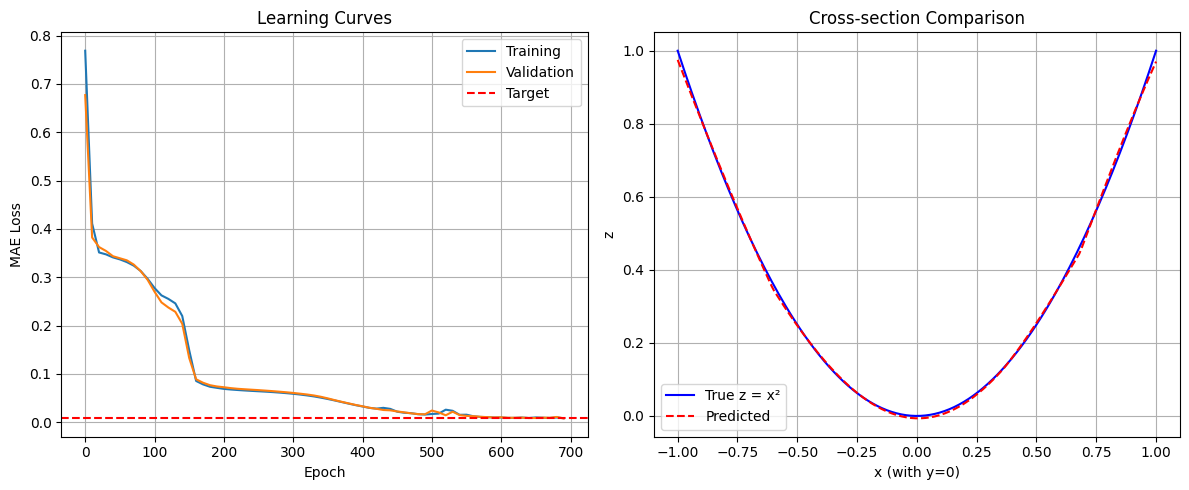

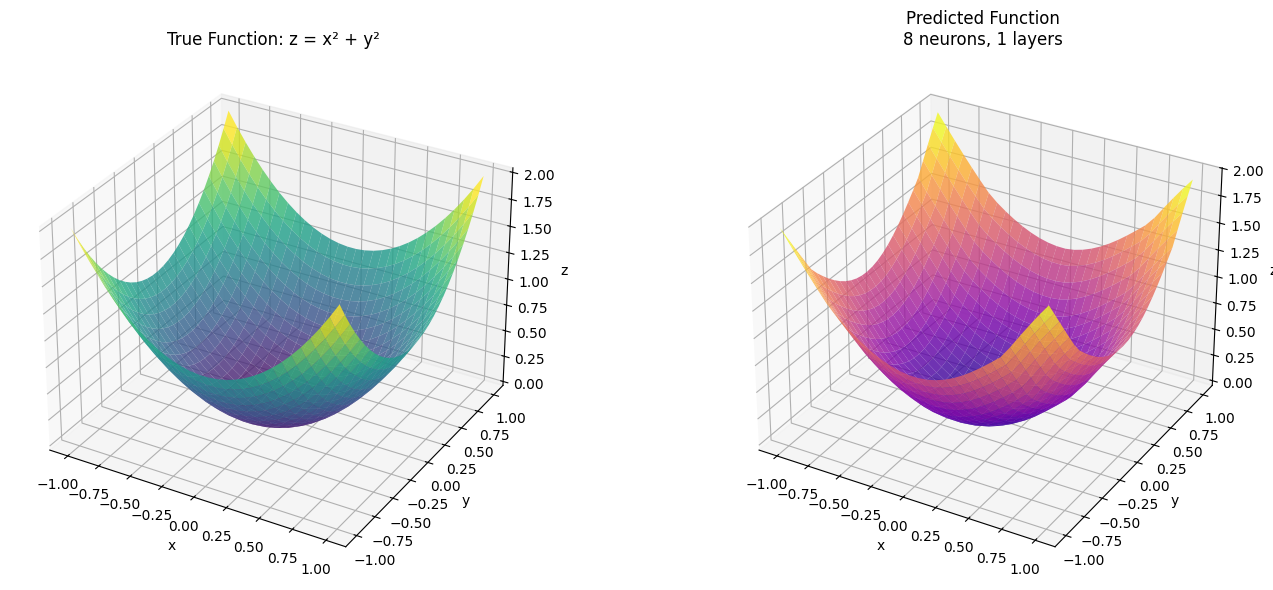